## Add a time-series model to the stacking model

### Background
Since matches are time dependant, it's possible to model a team's margins across time, much like a stock price. This means that we can use a time-series model (e.g. ARIMA) to forecast a team's match margins into the future. We would need one model per team since it doesn't make sense to treat two unrelated matches with completely different teams as a sequence of related events.

### Hypothesis
Adding a time-series model will improve the accuracy of the stacking model by adding new type of information (team margins as time-series) to the overall model.

## Code Setup

In [13]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
%autoreload 2

import math
import itertools

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from augury import model_tracking
from augury.ml_data import MLData
from augury.ml_estimators import StackingEstimator
from augury.sklearn import match_accuracy_scorer, create_match_accuracy, DataFrameConverter, year_cv_split
from augury.model_tracking import score_model
from augury.settings import CV_YEAR_RANGE, SEED, TRAIN_YEAR_RANGE, BASE_DIR, VALIDATION_YEAR_RANGE

np.random.seed(SEED)

In [3]:
data = MLData(train_year_range=(max(CV_YEAR_RANGE),))
data.data

2020-01-04 22:54:46,793 - kedro.io.data_catalog - INFO - Loading data from `model_data` (JSONLocalDataSet)...


team   oppo_team round_type  \
Adelaide         1991 1           Adelaide    Hawthorn    Regular   
                      2           Adelaide     Carlton    Regular   
                      3           Adelaide      Sydney    Regular   
                      4           Adelaide    Essendon    Regular   
                      5           Adelaide  West Coast    Regular   
...                                    ...         ...        ...   
Western Bulldogs 2019 20  Western Bulldogs    Brisbane    Regular   
                      21  Western Bulldogs    Essendon    Regular   
                      22  Western Bulldogs         GWS    Regular   
                      23  Western Bulldogs    Adelaide    Regular   
                      24  Western Bulldogs         GWS     Finals   

                                      venue prev_match_oppo_team  \
Adelaide         1991 1       Football Park                    0   
                      2       Football Park             Hawthorn   
                      3              S.C.G.              Carlton   
                      4          Windy Hill               Sydney   
                      5             Subiaco             Essendon   
...                                     ...                  ...   
Western Bulldogs 2019 20              Gabba            Fremantle   
                      21          Docklands             Brisbane   
                      22  Sydney Showground             Essendon   
                      23     Eureka Stadium                  GWS   
                      24  Sydney Showground             Adelaide   

                         oppo_prev_match_oppo_team                      date  \
Adelaide         1991 1                  Melbourne 1991-03-22 03:56:00+00:00   
                      2                    Fitzroy 1991-03-31 03:56:00+00:00   
                      3                   Hawthorn 1991-04-07 03:05:00+00:00   
                      4            North Melbourne 1991-04-13 03:30:00+00:00   
                      5            North Melbourne 1991-04-21 05:27:00+00:00   
...                                            ...                       ...   
Western Bulldogs 2019 20                  Hawthorn 2019-08-04 02:58:00+00:00   
                      21             Port Adelaide 2019-08-10 03:30:00+00:00   
                      22                  Hawthorn 2019-08-18 03:05:00+00:00   
                      23               Collingwood 2019-08-25 03:30:00+00:00   
                      24                Gold Coast 2019-09-07 03:05:00+00:00   

                          team_goals  team_behinds  score  ...  \
Adelaide         1991 1           24            11    155  ...   
                      2           12             9     81  ...   
                      3           19            18    132  ...   
                      4            6            11     47  ...   
                      5            9            11     65  ...   
...                              ...           ...    ...  ...   
Western Bulldogs 2019 20          11            14     80  ...   
                      21          21            11    137  ...   
                      22          19            12    126  ...   
                      23          18            13    121  ...   
                      24           8             7     55  ...   

                          oppo_rolling_prev_match_goals_divided_by_rolling_prev_match_goals_plus_rolling_prev_match_behinds  \
Adelaide         1991 1                                                 0.0                                                   
                      2                                                 0.0                                                   
                      3                                                 0.0                                                   
                      4                                                 0.0                                                   
   

## Time-series models

In [144]:
class TimeSeriesEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, stats_model):
        self.stats_model = stats_model
        self._team_stats_models = {}
        self._scaler = StandardScaler()
        
    def fit(self, X, y):
        time_series_df = (
            X
            .assign(y=y, ds=X['date'].dt.date)
#             .assign(y=self._scaler.fit_transform(y.to_numpy().reshape(-1, 1)), ds=X['date'].dt.date)
            .sort_values('ds', ascending=True)
        )
        
        for team_name, team_df in time_series_df.groupby('team'):
            self._fit_team_model(team_name, team_df)
            
        return self
            
    def predict(self, X):
        team_predictions = [
            self._predict_with_team_model(X, team_name, team_model)
            for team_name, team_model in self._team_stats_models.items()
        ]
        
        return pd.concat(team_predictions, axis=0).sort_index()
#         return self._scaler.inverse_transform(pred_df.to_numpy().reshape(-1, 1))

    
class ProphetEstimator(TimeSeriesEstimator):
    def __init__(self, stats_model, uncertainty_samples=False, daily_seasonality=False, changepoint_prior_scale=2.0):
        super().__init__(stats_model)

        self.uncertainty_samples = uncertainty_samples
        self.daily_seasonality = daily_seasonality
        self.changepoint_prior_scale = changepoint_prior_scale

    def _fit_team_model(self, team_name, team_df):
        self._team_stats_models[team_name] = {
            'model': self.stats_model(
                uncertainty_samples=self.uncertainty_samples,
                daily_seasonality=self.daily_seasonality,
                changepoint_prior_scale=self.changepoint_prior_scale,
            ).fit(team_df[['ds', 'y']]),
            'max_date': team_df['ds'].max(),
        }
        
    @staticmethod
    def _predict_with_team_model(X, team_name, team_model):
        X_team = X[['team', 'date']].query('team == @team_name').sort_values('date', ascending=True)
        
        if not X_team.any().any():
            return pd.Series(name='yhat')

        min_date = X_team['date'].iloc[0].date()
        max_date = X_team['date'].iloc[-1].date()

        date_range = max_date - team_model['max_date']
        # date_range = max_date - min_date
        n_weeks = math.ceil(date_range.days / 7)
        
        future_df = team_model['model'].make_future_dataframe(periods=n_weeks, freq='W')
        # TODO: Oversimplification of mapping of X dates onto forecast dates that ignores bye weeks
        # and any other scheduling irregularities, but it's good enough for now
        forecast = team_model['model'].predict(future_df.iloc[-len(X_team):, :])
        forecast.index = X_team.index
        
        return forecast['yhat'].sort_index()


class StatsModelEstimator(TimeSeriesEstimator):
    def __init__(self, stats_model, order=(0, 0, 0), exog_cols=[]):
        super().__init__(stats_model)

        self.order = order
        self.exog_cols = exog_cols

    def _fit_team_model(self, team_name, team_df):
        ts_df = team_df.set_index('ds')['y']
        n_train_years = team_df['year'].drop_duplicates().count()
        
        # Need smaller p for teams with fewer seasons for training (looking at you GWS),
        # because higher p values raise weird calculation errors deep in statsmodels:
        # "On entry to DLASCL parameter number 4 had an illegal value"
        p_param = self.order[0] if n_train_years > 2 else min(4, self.order[0])
        order_param = (p_param, *self.order[1:])
        exog = team_df[self.exog_cols].to_numpy() if any(self.exog_cols) else None

        self._team_stats_models[team_name] = {
            'model': self.stats_model(ts_df, order=order_param, exog=exog).fit(),
            'max_date': ts_df.index.values.max(),
        }
        
    def _predict_with_team_model(self, X, team_name, team_model):
        team_df = X.query('team == @team_name')
        
        if not team_df.any().any():
            return pd.Series(name='yhat')
        
        ts_df = team_df.sort_values('date')
        ts_index = ts_df.index

        exog = ts_df[self.exog_cols].to_numpy() if any(self.exog_cols) else None
        
        # TODO: Oversimplification of mapping of X dates onto forecast dates that ignores bye weeks
        # and any other scheduling irregularities, but it's good enough for now
        forecast, _se, _conf = team_model['model'].forecast(steps=len(ts_index), exog=exog)
        
        return pd.Series(forecast, name='yhat', index=ts_index)

### Prophet

In [102]:
prophet_scores = score_model(
    ProphetEstimator(
        Prophet, uncertainty_samples=False, daily_seasonality=False, changepoint_prior_scale=2.0
    ),
    data,
    n_jobs=-1
)

prophet_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


{'fit_time': array([77.59204316, 85.43071485, 81.24674916, 77.38712311, 39.9672215 ]),
 'score_time': array([4.87249708, 4.44664741, 4.44770217, 4.8554318 , 3.56786036]),
 'test_match_accuracy': array([0.60386473, 0.65048544, 0.61835749, 0.62318841, 0.66666667]),
 'test_neg_mean_absolute_error': array([-35.69778682, -38.41794495, -45.33944547, -34.65073615,
        -34.44991565])}

In [103]:
print('Mean accuracy:', prophet_scores['test_match_accuracy'].mean())
print('Mean MAE:', abs(prophet_scores['test_neg_mean_absolute_error'].mean()))

Mean accuracy: 0.6325125463158389
Mean MAE: 37.711165806485965


### ARIMA

In [73]:
data.train_year_range = TRAIN_YEAR_RANGE
X_train, y_train = data.train_data

X_ts = (
    X_train
    .assign(date=X_train['date'].dt.date, margin=y_train)
    .query('team == "Essendon"')
    .set_index('date')
    .loc[:, 'margin']
    .sort_index()
)

adf_test = sm.tsa.adfuller(X_ts.to_numpy())
print('p-value:', adf_test[1])

p-value: 8.34998554650595e-06


Data is stationary, do we can set `d` to 0 for ARIMA.

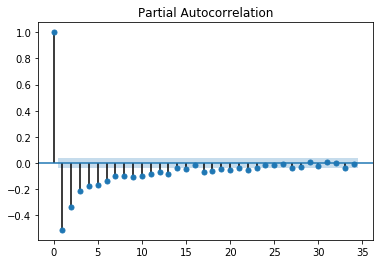

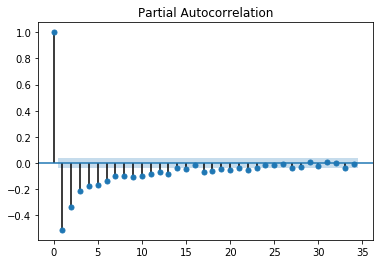

In [74]:
plot_pacf(np.diff(X_ts.to_numpy()))

Lags are correlated through 13 steps, but I'll use 12 for `p` to make it roughly half a season (average number of matches played by a team in a season is currently 23).

**Update:** High values of `p` have a tendency to break things for smaller data sets (e.g. GWS's matches), and a little trial-and-error showed 6 getting better results than 12 anyway.

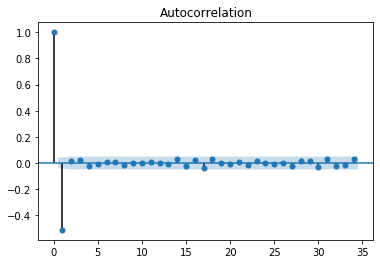

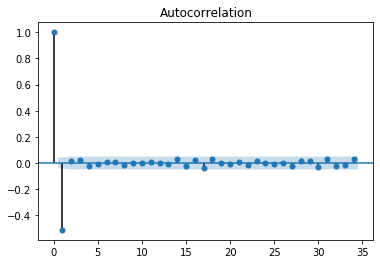

In [75]:
plot_acf(np.diff(X_ts.to_numpy()))

Just one lag step is significant, so I'll use 1 for `q`.

In [76]:
p = 6
d = 0
q = 1

arima_model = sm.tsa.ARIMA(X_ts, order=(p, d, q))
arima_fit = arima_model.fit()
arima_fit.summary()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 margin   No. Observations:                 2403
Model:                     ARMA(6, 1)   Log Likelihood              -12127.240
Method:                       css-mle   S.D. of innovations             37.625
Date:                Sat, 04 Jan 2020   AIC                          24272.481
Time:                        00:40:23   BIC                          24324.541
Sample:                             0   HQIC                         24291.419
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.7207      3.455      1.656      0.098      -1.052      12.493
ar.L1.margin     0.9829      0.025     38.872      0.000       0.933       1.032
ar.L2.margin     0.0275      0.029      0.962      0.336      -0.029       0.084
ar.L3.margin    -0.0043      0.029     -0.151      0.880      -0.060       0.052
ar.L4.margin    -0.0437      0.029     -1.526      0.127      -0.100       0.012
ar.L5.margin     0.0042      0.029      0.147      0.883      -0.052       0.060
ar.L6.margin     0.0186      0.022      0.863      0.388      -0.024       0.061
ma.L1.margin    -0.9323      0.015    -61.800      0.000      -0.962      -0.903
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0150           -0.0000j            1.0150           -0.0000
AR.2            1.6672           -1.1992j            2.0537           -0.0992
AR.3            1.6672           +1.1992j            2.0537            0.0992
AR.4           -0.9855           -1.9616j            2.1952           -0.3241
AR.5           -0.9855           +1.9616j            2.1952            0.3241
AR.6           -2.6049           -0.0000j            2.6049           -0.5000
MA.1            1.0726           +0.0000j            1.0726            0.0000
-----------------------------------------------------------------------------
"""

In [98]:
data.train_year_range = (max(CV_YEAR_RANGE),)
sme = StatsModelEstimator(sm.tsa.ARIMA, order=(p, d, q))

arima_scores = score_model(sme, data, n_jobs=-1)

arima_scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



[CV]  ................................................................


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided,

[CV] ................................................. , total=  29.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.1s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/stats

[CV] ................................................. , total=  30.9s
[CV]  ................................................................


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided,

[CV] ................................................. , total=  31.5s
[CV]  ................................................................


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided,

[CV] ................................................. , total=  30.6s
[CV]  ................................................................


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided,

[CV] ................................................. , total=  32.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min finished


{'fit_time': array([28.75506592, 30.49268126, 31.21105933, 30.27514172, 32.02609777]),
 'score_time': array([0.30684328, 0.42045903, 0.30906343, 0.3299129 , 0.36518669]),
 'test_match_accuracy': array([0.68599034, 0.63106796, 0.61835749, 0.62318841, 0.69082126]),
 'test_neg_mean_absolute_error': array([ -34.73889106,  -36.70045829,  -39.18354018, -122.07257394,
         -31.00325025])}

In [100]:
print('Mean accuracy:', arima_scores['test_match_accuracy'].mean())
print('Mean MAE:', abs(arima_scores['test_neg_mean_absolute_error'].mean()))

Mean accuracy: 0.6498850898175508
Mean MAE: 52.73974274419463


### ARIMA performs better than Prophet

ARIMA has higher accuracy and, except for the weird outlier in the 2017 fold, comparable MAE. The performance of both models depend heavily on their params, so there may be cases where Prophet could perform better, but ARIMA is good enough to try as a base regressor in the stacking estimator.

## StackingEstimator with time-series model

### Add ARIMA to base regressors

In [147]:
tip = context.catalog.load('tipresias_2020')
tip.pipeline.regressors

2020-01-06 08:55:37,980 - kedro.io.data_catalog - INFO - Loading data from `tipresias_2020` (PickleLocalDataSet)...


[Pipeline(memory=None,
          steps=[('dataframeconverter',
                  DataFrameConverter(columns=Index(['team', 'oppo_team', 'round_type', 'venue', 'prev_match_oppo_team',
        'oppo_prev_match_oppo_team', 'date', 'year', 'round_number', 'at_home',
        ...
        'oppo_rolling_prev_match_goals_divided_by_rolling_prev_match_goals_plus_rolling_prev_match_behinds',
        'win_odds', 'oppo_win_odds', 'line_...
                  ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                      criterion='mse', max_depth=None,
                                      max_features='auto', max_leaf_nodes=None,
                                      max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                 

In [148]:
p = 6
d = 0
q = 1

arima_pipeline = make_pipeline(
    DataFrameConverter(),
    StatsModelEstimator(sm.tsa.ARIMA, order=(p, d, q))
)
arima_meta_pipeline = clone(tip.pipeline)
arima_meta_pipeline.regressors.append(arima_pipeline)
tip.pipeline = arima_meta_pipeline

In [118]:
data.train_year_range = (max(CV_YEAR_RANGE),)
stack_scores = score_model(se, data, n_jobs=-1)

stack_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


{'fit_time': array([164.09756398, 179.06769586, 185.19196653, 189.1658771 ,
        142.85820794]),
 'score_time': array([0.70615315, 0.7790153 , 0.62040424, 0.63981414, 0.63532186]),
 'test_match_accuracy': array([0.73913043, 0.74271845, 0.7294686 , 0.70048309, 0.73429952]),
 'test_neg_mean_absolute_error': array([-28.84591787, -29.8806068 , -27.93173913, -27.44521739,
        -25.96471014])}

In [119]:
print('Mean accuracy:', stack_scores['test_match_accuracy'].mean())
print('Mean MAE:', abs(stack_scores['test_neg_mean_absolute_error'].mean()))

Mean accuracy: 0.7292200178228039
Mean MAE: 28.01363826743586


In [152]:
se.pipeline.meta_regr_[-1].feature_importances_

array([9.37796355e-01, 6.21752774e-02, 2.83674141e-05])

#### ARIMA's performance isn't good enough to impact overall performance

The relative performance of each base model determines how much it impacts the meta-regressor's predictions, as shown in its feature importances. This means that for any base model to have enough of an effect to be worth including in the stacking estimator, it probably has to be good enough to achieve an average accuracy close to 70%, which the Elo model currently does.

### Optimise ARIMA

In [145]:
p = 6
d = 0
q = 1
exog_cols = ['at_home', 'oppo_cum_percent']
data.train_year_range = (1965, max(CV_YEAR_RANGE))

sme = StatsModelEstimator(sm.tsa.ARIMA, order=(p, d, q), exog_cols=exog_cols)

arima_scores = score_model(sme, data, -1)

print('Mean accuracy:', arima_scores['test_match_accuracy'].mean())
print('Mean MAE:', abs(arima_scores['test_neg_mean_absolute_error'].mean()))

arima_scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



[CV]  ................................................................


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided,

[CV] ................................................. , total=  39.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.2s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/stats

[CV] ................................................. , total=  40.5s
[CV]  ................................................................


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided,

[CV] ................................................. , total=  39.7s
[CV]  ................................................................


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided,

[CV] ................................................. , total=  42.2s
[CV]  ................................................................


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

[CV] ................................................. , total=  42.2s
Mean accuracy: 0.6837531072651377
Mean MAE: 32.21370262369353


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.4min finished


{'fit_time': array([38.82461047, 40.18519402, 39.37376785, 41.82832479, 41.73630285]),
 'score_time': array([0.37221456, 0.34943271, 0.3447156 , 0.33443236, 0.46832561]),
 'test_match_accuracy': array([0.70531401, 0.68446602, 0.69565217, 0.62801932, 0.70531401]),
 'test_neg_mean_absolute_error': array([-34.39430199, -32.88611701, -34.14910177, -30.71024797,
        -28.92874437])}

#### Adding if a team is at home & their opposition's strength makes ARIMA competitive

The MAE is still pretty high, but an accuracy of 68.4% at least puts this ARIMA model in the same league as the Elo and ML base models, which should make it more important in the meta-estimator's predictions.

### Try adding ARIMA to base regressors again

In [150]:
p = 6
d = 0
q = 1

arima_pipeline = make_pipeline(
    DataFrameConverter(),
    StatsModelEstimator(sm.tsa.ARIMA, order=(p, d, q), exog_cols=exog_cols)
)
arima_meta_pipeline.regressors[-1] = arima_pipeline
tip.pipeline = arima_meta_pipeline

In [154]:
data.train_year_range = (max(CV_YEAR_RANGE),)
stack_scores = score_model(tip, data, n_jobs=-1)

stack_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.4min finished


{'fit_time': array([154.00514007, 159.32126689, 162.87614751, 169.60986924,
        167.07702804]),
 'score_time': array([0.63787556, 0.6777401 , 0.65728164, 0.65203953, 0.68075943]),
 'test_match_accuracy': array([0.73429952, 0.73300971, 0.72463768, 0.70048309, 0.76328502]),
 'test_neg_mean_absolute_error': array([-29.13888889, -29.88737864, -28.54323671, -27.15838164,
        -25.40342995])}

In [155]:
print('Mean accuracy:', stack_scores['test_match_accuracy'].mean())
print('Mean MAE:', abs(stack_scores['test_neg_mean_absolute_error'].mean()))

Mean accuracy: 0.7311430045495052
Mean MAE: 28.026263167768867


In [161]:
data.train_year_range = TRAIN_YEAR_RANGE
tip.fit(*data.train_data)
tip.pipeline.meta_regr_[-1].feature_importances_

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided,

array([0.94141154, 0.05038331, 0.00820515])

## Conclusion

### ARIMA doesn't add much yet, but has potential
Despite the improvement in its individual accuracy, ARIMA still doesn't have much of an impact on the final model's predictions (< 1%). However, seeing how important params are to statistical models (Elo is similar), some param tuning could improve it enough for ARIMA to make a noticeable contribution to the final model. It adds a bit to train times, but I want to see if it eventually pays off, so I'll include it for now.